<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 

dtype = torch.float
device = torch.device("cpu") 

!rm -rf main_dir
!rm -rf data.zip


m = 1 # 1 to import local file, 2 to import from drive

if (m == 1): 
  from google.colab import files
  uploaded = files.upload()
  data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')

if (m == 2): 
  from google.colab import drive
  drive.mount('/content/drive/')

  data = zipfile.ZipFile("/content/drive/My Drive/Research project/data2/data.zip", 'r')



root_dir = "main_dir"
data.extractall(root_dir)
data.close()





Saving data.zip to data.zip


In [0]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

transforms = transforms.Compose( [Resize((100, 120), 1), # Not necessary if data generated with this format
                                  ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transforms)

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transforms)

idx_to_class = {j:i for i,j in train_data.class_to_idx.items()}


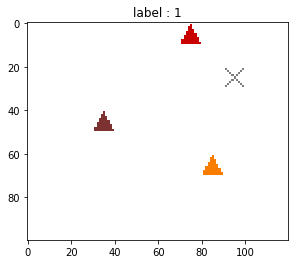

In [14]:
def display_image(image, label): 
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  plt.title("label : " + idx_to_class[label])

display_image(train_data[-1][0], train_data[-1][1])



In [0]:
batch_Size = 32
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

train_loader = iter(dataloader)
x,y = next(train_loader)



https://www.youtube.com/watch?v=fXEdtz8U3Sc

In [0]:
import torch.nn as nn
import torch.nn.functional as F







class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) #or 16 * 5 * 5 ### now 16*6*5
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net()


In [0]:
import torch.optim as optim

regularization_strength = 0.001
learning_rate = 0.001
mom = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = mom, weight_decay = regularization_strength)

In [88]:
epochs = 4

loss_list = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      """
      # For L1 loss, manual impleementation is necessary. L2 can be done in optimizer directly
      L1_reg = torch.tensor(0., requires_grad=True)
      for name, param in net.named_parameters():
        if 'weight' in name:
          L1_reg = L1_reg + torch.norm(param, p=2)

      loss += lambda_ * L1_reg
      """

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 400 == 399:    # print every 400 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 400))
          running_loss = 0.0

print('Finished Training')


[1,   400] loss: 0.669
[1,   800] loss: 0.383
[2,   400] loss: 0.192
[2,   800] loss: 0.153
[3,   400] loss: 0.136
[3,   800] loss: 0.126
[4,   400] loss: 0.088
[4,   800] loss: 0.018
Finished Training


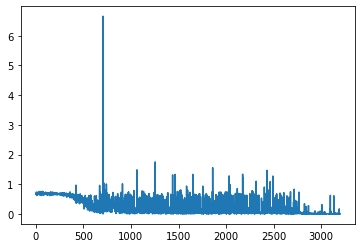

In [89]:
plt.plot(loss_list)

In [90]:
correct = 0
total = 0
wrong_im = []
wrong_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        k = 0
        for truth in (predicted == labels): 
          if not truth: 
            wrong_im.append(images[k])
            wrong_label.append(int(labels[k]))
          k += 1
        
        

print("Accuracy of the network on the " + str(total) + ' test images: %d %%' % (
    100 * correct / total))

print("Number of mistakes : " +str(total-correct))
index = 0

Accuracy of the network on the 800 test images: 99 %
Number of mistakes : 2


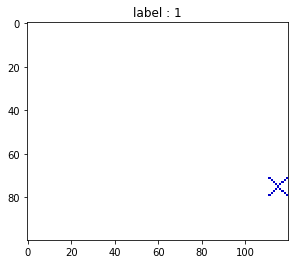

In [91]:
if index in range(len(wrong_im)):
  display_image(wrong_im[index], wrong_label[index])
  index += 1

In [0]:
index = 0